# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import prince
import matplotlib.pyplot as plt
from adjustText import adjust_text
import sklearn as sk 
from sklearn.cluster import AgglomerativeClustering

# Introdução

A análise de correspondência é uma técnica exploratório que serve para encontrar associações entre variáveis categoricas como sexo, profissão e cor favorita. Ela é muito útil visto que muitas métodos utilizados em variáveis numéricas não se aplicam a variáveis categóricas que podem ajudar a revelar muita informação relevante de uma determinada amostra de dados. Neste estudo busquei utilizar a análise de correspondência múltiplica (MCA) em uma base de dados de uma pesquisa de marketing realizada por um banco português e tentar encontrar associações entre as mais diferentes variáveis como profissão, faixa etária e educação. 

# Preparando a Base de Dados

## Extração da Base de Dados

Os dados são de uma pesquisa de marketing de um banco português e contém mais de 45 mil observações de clientes da instituição. 

Bank Marketing: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [2]:
data_original = pd.read_csv(r"C:\Users\emanu\OneDrive\Área de Trabalho\bank-full.csv", sep=';')
data_original

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Filtragem das Variáveis

Abaixo nós transformamos as variáveis 'balance' que calcula o balanço médio anual dos clientes e o 'age' que se refere a idade em variáveis categóricas que são faixas de idade e se o cliente é devedor, credor ou altamente credor. Isso é uma passo importante pois a análise de correspondência serve para analisar variáveis categóricas e não numéricas.

In [3]:
age_bins = [18, 25, 45, 64, 100]
age_labels = ['young adult', 'adult', 'middle age', 'senior']

balance_bins = [-9000, 0, 20000, 110000]
balance_labels = ['Debtor', 'Creditor', 'High Creditor']

data_original['age_adj'] = pd.cut(data_original['age'], bins=age_bins, labels=age_labels, right=False)
data_original['balance_adj'] = pd.cut(data_original['balance'], bins=balance_bins, labels=balance_labels, right=False)

In [4]:
data = data_original[['job','age_adj','balance_adj','education']]
data = data[data != 'unknown'].dropna()
data

,job,age_adj,balance_adj,education
0,management,middle age,Creditor,tertiary
1,technician,adult,Creditor,secondary
2,entrepreneur,adult,Creditor,secondary
5,management,adult,Creditor,tertiary
6,management,adult,Creditor,tertiary
...,...,...,...,...
45206,technician,middle age,Creditor,tertiary
45207,retired,senior,Creditor,primary
45208,retired,senior,Creditor,secondary
45209,blue-collar,middle age,Creditor,secondary


Abaixo extraímos a contagem do número de observações de cada uma das categorias.

In [5]:
for i in data.columns:
    print(data[i].value_counts())
    print('')

job
blue-collar      9278
management       9216
technician       7355
admin.           5000
services         4004
retired          2145
self-employed    1540
entrepreneur     1411
unemployed       1274
housemaid        1195
student           775
Name: count, dtype: int64

age_adj
adult          27820
middle age     13855
senior           789
young adult      729
Name: count, dtype: int64

balance_adj
Creditor         39371
Debtor            3634
High Creditor      188
Name: count, dtype: int64

education
secondary    23131
tertiary     13262
primary       6800
Name: count, dtype: int64



Abaixo geramos tabelas de contigência para cada par de variáveis, podemos a partir dela já inferir de forma preliminar a existência de algumas relação entre elas. Por exemplo, clientes idosos ('senior') são em sua maioria aposentados ('retired'), cliente que atuam na área de gestão ('management') possuem melhor educação ('tertiary'), clientes que são donas de casa ('housemaid') possuem educação mais baixa ('primary')

In [6]:
for i in data.columns[1:]:
    print(pd.crosstab(data['job'], data[f'{i}']))
    print('')

age_adj        young adult  adult  middle age  senior
job                                                  
admin.                  89   3459        1441      11
blue-collar            142   6195        2934       7
entrepreneur             5    868         531       7
housemaid                6    516         641      32
management              37   6287        2851      41
retired                  1     64        1416     664
self-employed            9   1029         496       6
services                82   2841        1081       0
student                266    509           0       0
technician              77   5243        2019      16
unemployed              15    809         445       5

balance_adj    Debtor  Creditor  High Creditor
job                                           
admin.            476      4512             12
blue-collar      1060      8208             10
entrepreneur      108      1288             15
housemaid          38      1151              6
management     

## Teste Qui-Quadrado ($\chi^2$)

O primeiro passo antes de fazer a análise de correspondência é realizar o teste qui-quadrado ($\chi^2$) que serve para saber se há associação estatística significativa entre as variáveis da nossa base de dados. Esse passo é importantíssimo pois não faria sentido fazer uma análise de correspondência entre variáveis que não apresentam relações entre si. 

Como pode-se observar abaixo, em todos os testes que fizemos podemos rejeitar a hipótese nula ($H_0$) e afirmar que há associação estatística significativa entre as variáveis ao nível de significância de 5%. 

In [7]:
tabelas_cross = {}
tab_results = {}

for i in data.columns[1:]:
    tabela_cross = pd.crosstab(data['job'], data[f"{i}"])
    chi2_result = chi2_contingency(tabela_cross)
    
    tabelas_cross[f'tabela_cross_{i}'] = tabela_cross
    tab_results[f'tab_{i}'] = chi2_result
    
    print(f'Variáveis: {data.columns[0]} x {i}')
    print(f'Estatística qui²: {round(chi2_result[0], 2)}')
    print(f'P-valor da estatística: {round(chi2_result[1], 4)}')
    print(f'Graus de liberdade: {chi2_result[2]}')
    print('')

Variáveis: job x age_adj
Estatística qui²: 18385.36
P-valor da estatística: 0.0
Graus de liberdade: 30

Variáveis: job x balance_adj
Estatística qui²: 503.82
P-valor da estatística: 0.0
Graus de liberdade: 20

Variáveis: job x education
Estatística qui²: 26565.66
P-valor da estatística: 0.0
Graus de liberdade: 20



# Análise de Correspondência Múltipla - ACM

A análise de correspondência múltipla (ACM) é utilizada para identificar associação entre mais de duas variáveis categóricas, esta associação é demonstrado por meio da transformação destas categorias em coordenados que são plotadas em um gráfico chamado de mapa perceptual. Neste mapa perceptual podemos vizualizar se uma categoria está próxima ou distante da outra e a partir disto inferir se há alguma associação entre elas.

A biblioteca utilizada é a prince e a principal referência bibliográfico é o livro Manual de Análise de Dados do Favero.

Biblioteca: https://maxhalford.github.io/prince/mca/

In [8]:
# mca = multiple correspondence analysis
mca = prince.MCA(n_components=20).fit(data)
mca

MCA(n_components=20)

## Matriz Binária

Conforme explicado por Favero, a partir da matriz de dados original podemos criar uma matriz binária que indica a presença (1) ou ausência (0) de alguma categoria em uma determinava observação. Por exemplo, na primeira observação o cliente tem o job (variável) management (categoria) e, portanto, foi assinalado na matriz binária como 1 que indica presença enquanto as demais profissões receberam o valor 0 visto serem auto-excludentes.

In [9]:
binaria = pd.get_dummies(data, columns=data.columns, dtype=float)
binaria

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age_adj_young adult,age_adj_adult,age_adj_middle age,age_adj_senior,balance_adj_Debtor,balance_adj_Creditor,balance_adj_High Creditor,education_primary,education_secondary,education_tertiary
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
45207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
45209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Matriz de Burt

A matriz de burt é o produto da matriz binária (X) pela sua inversa (X.T), é de se notar que essa operação da origem a uma matriz quadrada e simétrica com o número de linhas e colunas igual ao número de categorias. 

In [10]:
burt = np.matmul(binaria.T, binaria) # pode também ser calculado com o np.dot
burt

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age_adj_young adult,age_adj_adult,age_adj_middle age,age_adj_senior,balance_adj_Debtor,balance_adj_Creditor,balance_adj_High Creditor,education_primary,education_secondary,education_tertiary
job_admin.,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,3459.0,1441.0,11.0,476.0,4512.0,12.0,209.0,4219.0,572.0
job_blue-collar,0.0,9278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,142.0,6195.0,2934.0,7.0,1060.0,8208.0,10.0,3758.0,5371.0,149.0
job_entrepreneur,0.0,0.0,1411.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,868.0,531.0,7.0,108.0,1288.0,15.0,183.0,542.0,686.0
job_housemaid,0.0,0.0,0.0,1195.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,516.0,641.0,32.0,38.0,1151.0,6.0,627.0,395.0,173.0
job_management,0.0,0.0,0.0,0.0,9216.0,0.0,0.0,0.0,0.0,0.0,...,37.0,6287.0,2851.0,41.0,561.0,8571.0,84.0,294.0,1121.0,7801.0
job_retired,0.0,0.0,0.0,0.0,0.0,2145.0,0.0,0.0,0.0,0.0,...,1.0,64.0,1416.0,664.0,117.0,2007.0,21.0,795.0,984.0,366.0
job_self-employed,0.0,0.0,0.0,0.0,0.0,0.0,1540.0,0.0,0.0,0.0,...,9.0,1029.0,496.0,6.0,84.0,1446.0,10.0,130.0,577.0,833.0
job_services,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4004.0,0.0,0.0,...,82.0,2841.0,1081.0,0.0,471.0,3527.0,6.0,345.0,3457.0,202.0
job_student,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,775.0,0.0,...,266.0,509.0,0.0,0.0,9.0,763.0,3.0,44.0,508.0,223.0
job_technician,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7355.0,...,77.0,5243.0,2019.0,16.0,636.0,6702.0,17.0,158.0,5229.0,1968.0


## Decomposição de Valores Singulares

A análise de correspondência apresenta uma abordagem similar ao PCA onde precisamos fazer a decomposição de uma matriz em autovalores e autovetores, no MCA fazemos a decomposição da matriz de resíduos padronizados por meio da Decomposição por Valores Singulares (Singular Value Decomposition - SVD) que é uma forma de decomposição de matrizes que diferente do PCA não exige que a matriz seja quadrada e simétrica. Os detalhes dos cálculos estão nos links abaixo que foram recomendados pelo autor da biblioteca prince e tentamos reproduzir manualmente nas celulas a seguir. 

Theory of Correspondence Analysis: https://statmath.wu.ac.at/courses/CAandRelMeth/caipA.pdf

Computation of Multiple Correspondence Analysis: https://core.ac.uk/reader/6591520

In [11]:
# Matriz de Correspondência
n = np.sum(burt.values)
P = (burt/n).values

# Massas
r = np.sum(P, axis=1) # row
c = np.sum(P, axis=0) # column

# Matriz Diagonal
D_r = np.diag(1 / np.sqrt(r)) # row
D_c = np.diag(1 / np.sqrt(c)) # column

# Muda o formato das matrizes de linha para coluna
r = r.reshape(-1, 1)  
c = c.reshape(1, -1) 
P_minus_rcT = P - r @ c # O operador @ realiza a mesma operação que np.dot()

# Matriz de resíduos padronizados (S)
S = D_r @ P_minus_rcT @ D_c

print("Matrix S (Standardized Residuals)")
pd.DataFrame(S)

Matrix S (Standardized Residuals)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.221060,-0.039422,-0.015374,-0.014148,-0.039290,-0.018955,-0.016061,-0.025898,-0.011394,-0.035100,...,0.000604,0.005057,-0.004891,-0.010112,0.003245,-0.000812,-0.002517,-0.024789,0.035831,-0.029571
1,-0.039422,0.196299,-0.020942,-0.019272,-0.053521,-0.025821,-0.021878,-0.035278,-0.015520,-0.047813,...,-0.001403,0.003411,-0.000928,-0.015013,0.012030,-0.003257,-0.005751,0.072307,0.006867,-0.060845
2,-0.015374,-0.020942,0.241833,-0.007516,-0.020872,-0.010069,-0.008532,-0.013757,-0.006053,-0.018646,...,-0.004638,-0.001628,0.004433,-0.004448,-0.001183,0.000062,0.004300,-0.003159,-0.009348,0.014608
3,-0.014148,-0.019272,-0.007516,0.243083,-0.019208,-0.009267,-0.007852,-0.012661,-0.005570,-0.017159,...,-0.003795,-0.010999,0.015832,0.002619,-0.007503,0.002250,0.000421,0.038489,-0.011648,-0.012178
4,-0.039290,-0.053521,-0.020872,-0.019208,0.196658,-0.025734,-0.021805,-0.035160,-0.015469,-0.047653,...,-0.011434,0.005482,-0.002328,-0.011806,-0.009261,0.002238,0.008335,-0.036535,-0.065313,0.112418
5,-0.018955,-0.025821,-0.010069,-0.009267,-0.025734,0.237585,-0.010520,-0.016962,-0.007463,-0.022990,...,-0.007038,-0.042640,0.033383,0.120072,-0.005683,0.001409,0.004592,0.029935,-0.005846,-0.013715
6,-0.016061,-0.021878,-0.008532,-0.007852,-0.021805,-0.010520,0.241087,-0.014373,-0.006323,-0.019480,...,-0.004009,0.001417,0.000109,-0.005019,-0.004815,0.001357,0.001532,-0.008687,-0.010376,0.019924
7,-0.025898,-0.035278,-0.013757,-0.012661,-0.035160,-0.016962,-0.014373,0.226825,-0.010196,-0.031410,...,0.002110,0.006208,-0.006826,-0.010288,0.008791,-0.002443,-0.003293,-0.013672,0.034102,-0.035247
8,-0.011394,-0.015520,-0.006053,-0.005570,-0.015469,-0.007463,-0.006323,-0.010196,0.245514,-0.013819,...,0.084122,0.000529,-0.018966,-0.004526,-0.008373,0.002561,-0.000244,-0.008495,0.005489,-0.001166
9,-0.035100,-0.047813,-0.018646,-0.017159,-0.047653,-0.022990,-0.019480,-0.031410,-0.013819,0.207429,...,-0.005089,0.008839,-0.008427,-0.012283,0.000831,-0.000032,-0.003192,-0.035348,0.024729,-0.007348


In [12]:
# Singular Value Decomposition - SVD
U, D_a, Vt = np.linalg.svd(S, full_matrices=False)
D_a[:5]

array([0.43355274, 0.40717283, 0.34006403, 0.32439034, 0.26620348])

Abaixo podemos comparar os autovalores (inercias) extraídos com o que é obtido pela biblioteca prince e verificar que obtemos os mesmos resultados. 

In [13]:
mca.eigenvalues_[:5]

array([0.43355274, 0.40717283, 0.34006403, 0.32439034, 0.26620348])

## Coordenadas

Abaixo geramos as coordenadas das colunas (variáveis) que usaremos para criar o mapa perceptual, é possível observar que para cada dimensão há um conjunto de coordenadas. Dividimos o valor obtido pela .column_coordinates() pela raiz quadrada dos autovalores para obter as coordenadas padrões.

É possível notar que temos 20 conjuntos de coordenadas, assim como no PCA buscamos os fatores mais significativos com base na magnitude dos autovalores, no MCA faremos algo similar escolhendo as dimensões (coordenadas) associadas aos maiores autovalores (inerciais principais). 

In [14]:
coord_padrao = mca.column_coordinates(data)/np.sqrt(mca.eigenvalues_)
coord_padrao

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
job_admin.,0.203250,-1.246874,0.437106,-1.375668,1.171455,0.649945,0.286567,1.646081e-15,-6.282525e-01,4.472896e+00,-0.682912,0.141776,0.442485,0.262250,-1.785850,0.349328,-0.730884,-3.492796e+15,-2.741965e+15,2.623566e+15
job_blue-collar,1.270461,-0.443303,-1.314453,1.370556,-1.555643,-0.285509,0.620611,-3.314834e-01,-2.203418e-01,3.235079e-01,0.250220,0.591551,-0.861588,0.141213,1.607918,0.332592,-1.477925,-3.492796e+15,-2.741965e+15,2.623566e+15
job_entrepreneur,-0.628785,0.543755,-0.482603,0.202038,1.795933,5.308645,4.688702,-2.136468e+00,-2.377471e+00,-3.370860e+00,-6.102411,1.352578,1.571862,0.431058,0.353187,0.096543,0.807245,-3.492796e+15,-2.741965e+15,2.623566e+15
job_housemaid,1.518363,1.173331,-1.793632,2.482106,6.100709,-0.676326,-5.219972,-2.030895e+00,1.123560e+00,-2.426381e-01,0.463682,1.086692,6.730356,0.222579,3.024935,-0.625436,-0.929776,-3.492796e+15,-2.741965e+15,2.623566e+15
job_management,-1.993999,1.333888,-0.162333,0.436394,-0.672203,0.198413,-1.061285,4.424212e-01,-3.028059e-01,5.648043e-01,0.012819,-0.250373,-0.473217,0.202019,0.646932,0.263825,2.394823,-3.492796e+15,-2.741965e+15,2.623566e+15
job_retired,3.075991,3.948406,2.667472,-2.189724,-0.743259,0.115083,0.055814,8.606760e-02,-1.818943e-02,-6.858168e-03,-0.172309,-0.860242,-0.387784,-0.866009,0.518538,-6.067636,-0.502725,-3.492796e+15,-2.741965e+15,2.623566e+15
job_self-employed,-0.965612,0.494658,-0.187175,0.039508,1.233661,-1.573887,5.262392,-2.916362e-01,8.343688e+00,2.778512e-01,0.658456,-1.591137,1.126795,0.296234,0.112137,0.248001,1.052589,-3.492796e+15,-2.741965e+15,2.623566e+15
job_services,0.463366,-1.423761,0.263800,-1.144092,-0.372677,1.707281,-2.777194,2.497012e+00,2.524020e+00,-2.256227e+00,-1.125273,1.159438,-0.887405,0.205506,-1.527625,0.430985,-1.052167,-3.492796e+15,-2.741965e+15,2.623566e+15
job_student,-0.331846,-2.109216,7.960532,6.464526,0.019401,-0.032504,0.214913,-4.180113e-01,-1.425887e-01,-3.258322e-01,-0.018864,-0.054547,0.595008,-10.231308,-1.088901,1.623113,-0.080340,-3.492796e+15,-2.741965e+15,2.623566e+15
job_technician,-0.324651,-0.786733,0.303587,-1.253801,0.384992,-1.431065,0.067369,-2.194290e+00,-1.078619e+00,-1.941264e+00,1.465360,-0.772486,-0.146904,0.387561,-1.447111,0.373420,-0.070566,-3.492796e+15,-2.741965e+15,2.623566e+15


## Dimensões

Segundo Fávero "somente é interessante que sejam plotadas no mapa perceptual as coordenadas das dimensões que apresentarem valores de inércia principal parcial superiores à média da inércia principal total por dimensão". No modelo abaixo, acabamos por escolher trabalhar com duas dimensões visto que apenas dois dos autovalores são maiores do a média.

In [15]:
tabela_autovalores = mca.eigenvalues_summary
tabela_autovalores

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.434,10.20%,10.20%
1,0.407,9.58%,19.78%
2,0.340,8.00%,27.78%
3,0.324,7.63%,35.42%
4,0.266,6.26%,41.68%
5,0.256,6.03%,47.71%
6,0.250,5.89%,53.60%
7,0.250,5.88%,59.48%
8,0.250,5.88%,65.37%


In [16]:
(mca.eigenvalues_).mean()

0.21250000000000008

Abaixo foram geradas as coordenadas para duas dimensões.

In [17]:
coord_padrao = mca.column_coordinates(data).iloc[:,0:2]/np.sqrt(mca.eigenvalues_[0:2])
coord_padrao

,0,1
job_admin.,0.203250,-1.246874
job_blue-collar,1.270461,-0.443303
job_entrepreneur,-0.628785,0.543755
job_housemaid,1.518363,1.173331
job_management,-1.993999,1.333888
job_retired,3.075991,3.948406
job_self-employed,-0.965612,0.494658
job_services,0.463366,-1.423761
job_student,-0.331846,-2.109216
job_technician,-0.324651,-0.786733


## Organização da Coordenadas

In [18]:
chart = coord_padrao.reset_index() # Cria uma coluna com os valores que estavam no index

var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0]) # Coluna que armaza o nome das variáveis

nome_categ=[]
for col in data:
    nome_categ.append(data[col].sort_values(ascending=True).unique()) # Extraí os valores únicos das categorias
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

# Dataframe que usaremos para construção do mapa perceptual e na clusterização
chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

chart_df_mca['Cores'] = pd.DataFrame(pd.factorize(chart_df_mca['variavel'])[0]) # Para coloriz os pontos no gráfico scatter

chart_df_mca

,categoria,obs_x,obs_y,variavel,categoria_id,Cores
0,job_admin.,0.203250,-1.246874,job,admin.,0
1,job_blue-collar,1.270461,-0.443303,job,blue-collar,0
2,job_entrepreneur,-0.628785,0.543755,job,entrepreneur,0
3,job_housemaid,1.518363,1.173331,job,housemaid,0
4,job_management,-1.993999,1.333888,job,management,0
5,job_retired,3.075991,3.948406,job,retired,0
6,job_self-employed,-0.965612,0.494658,job,self-employed,0
7,job_services,0.463366,-1.423761,job,services,0
8,job_student,-0.331846,-2.109216,job,student,0
9,job_technician,-0.324651,-0.786733,job,technician,0


## Gráfico

O gráfico abaixo é o resultado visual da nossa análise de correspondência, cada ponto representa uma categoria que é plotada com base nas coordenadas extraídas acima. Podemos vizualizar que algumas categorias estão mais próximas do que outras o que pode indicar algum grau de associação entre elas.

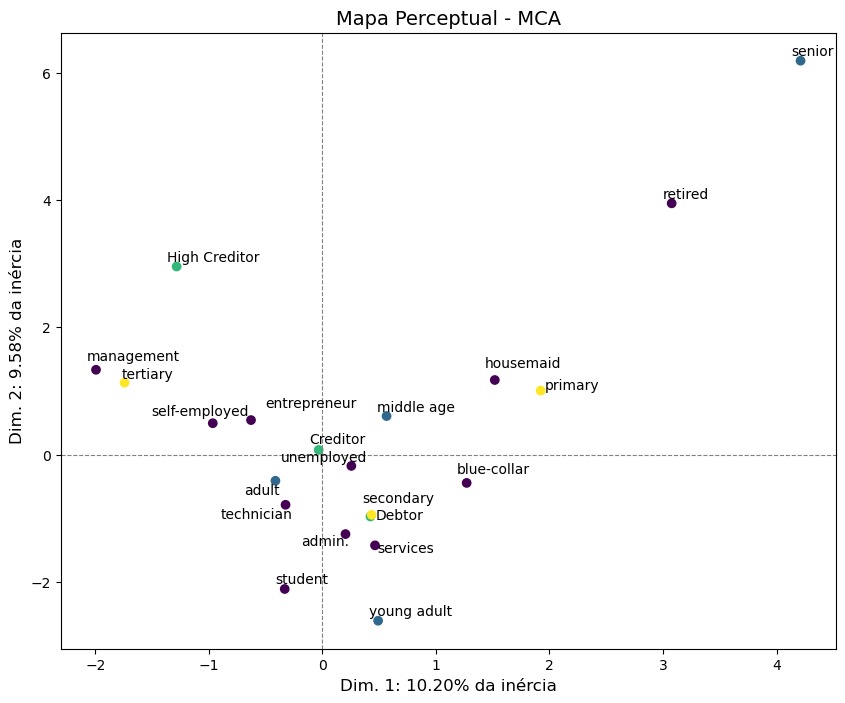

In [19]:
plt.figure(figsize=(10,8))

plt.scatter(chart_df_mca.iloc[:,1], chart_df_mca.iloc[:,2], c = chart_df_mca['Cores'])

texts = [] 
for i, txt in enumerate(chart_df_mca['categoria_id']):
    texts.append(plt.text(chart_df_mca.iloc[i, 1], chart_df_mca.iloc[i, 2], txt, ha='center'))

plt.axhline(y=0, color='grey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='grey', ls='--', linewidth=0.8)
plt.title("Mapa Perceptual - MCA", fontsize=14)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=12)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=12)
adjust_text(texts)

# Clusterização

Aproveitamos a base de dados construída acima e fazer uma análise de clusterização onde buscamos agrupar as categorias em clusters que pode nos ajudar a entender melhor a natureza dos nossos dados. O método utilizado foi o método hierárquico aglomerativo e para mais informações pode consultar o projeto de clusterização deste repositório. 

Text(0, 0.5, 'Distância Euclidiana')

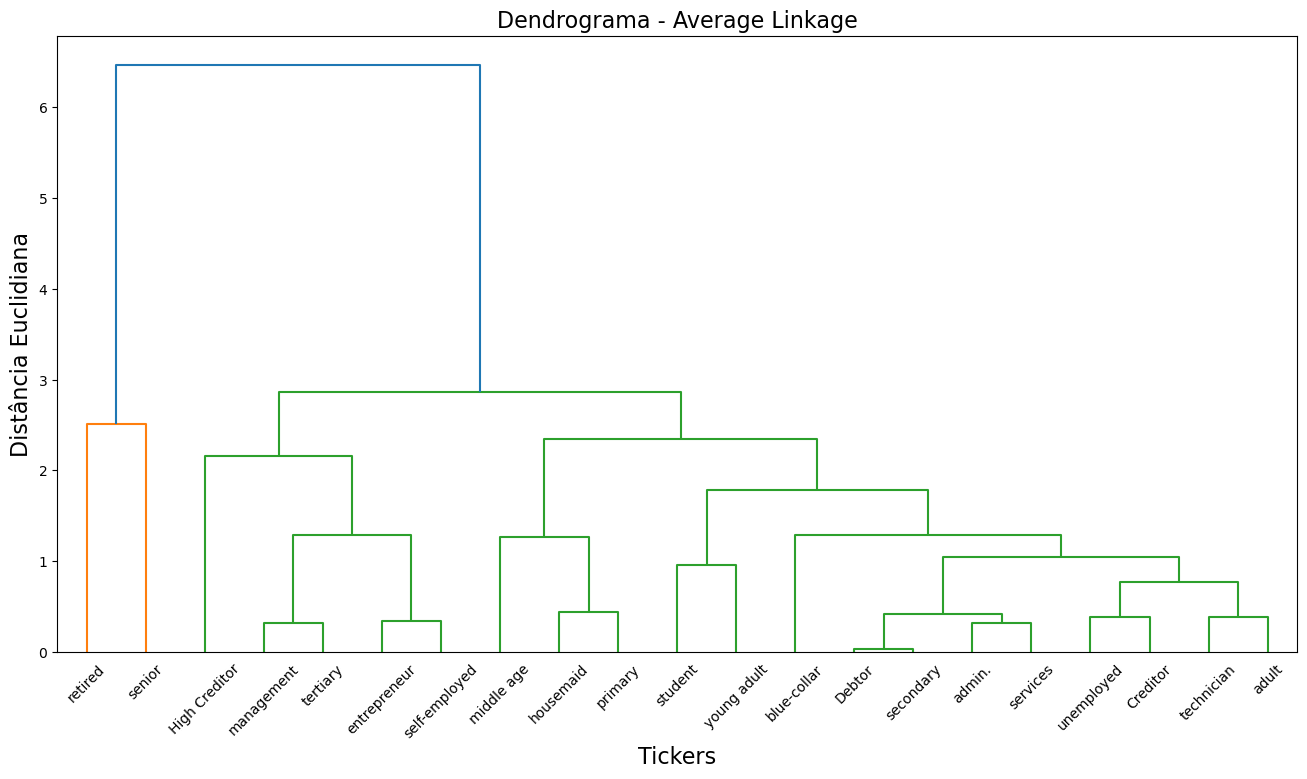

In [20]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(16,8))

h_linkage = sch.linkage(chart_df_mca[['obs_x', 'obs_y']], method = 'average', metric = 'euclidean')
dendrogram = sch.dendrogram(h_linkage, labels = list(chart_df_mca['categoria_id'].values))

plt.title('Dendrograma - Average Linkage', fontsize=16)
plt.xlabel('Tickers', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Distância Euclidiana', fontsize=16)

In [21]:
cluster_comp = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'average')
indica_cluster_comp = cluster_comp.fit_predict(chart_df_mca[['obs_x', 'obs_y']])
chart_df_mca['cluster_Average'] = indica_cluster_comp
chart_df_mca['cluster_Average'] = chart_df_mca['cluster_Average'].astype('category')

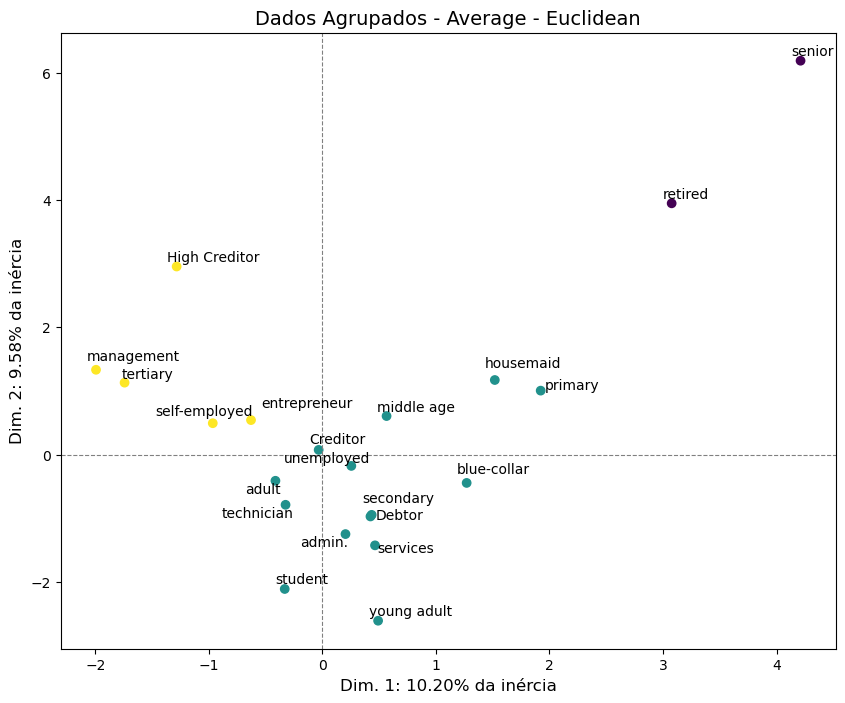

In [22]:
plt.figure(figsize=(10,8))

plt.scatter(chart_df_mca.iloc[:,1], chart_df_mca.iloc[:,2], c = chart_df_mca['cluster_Average'])

texts = [] 
for i, txt in enumerate(chart_df_mca['categoria_id']):
    texts.append(plt.text(chart_df_mca.iloc[i, 1], chart_df_mca.iloc[i, 2], txt, ha='center')) 
   
plt.axhline(y=0, color='grey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='grey', ls='--', linewidth=0.8)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=12)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=12)
plt.title('Dados Agrupados - Average - Euclidean', fontsize=14)
adjust_text(texts)

Segue o resumo dos clusters formados abaixo: 

- Idoso e Aposentado formaram um cluster o que é bastante intuitivo. 
- Empresários, Autonômos e Gestores formaram um cluster com ensino terciário e altamente credor. 
- O cluster mais abaixo que reúne as demais categorias apresentando bastante diversidade, entretanto podemos vizualizar que algumas categorias estão mais próximas do que outras como jovem adulto e estudante e emprega doméstica e ensino primário. 